<a href="https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/students/DogeBTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


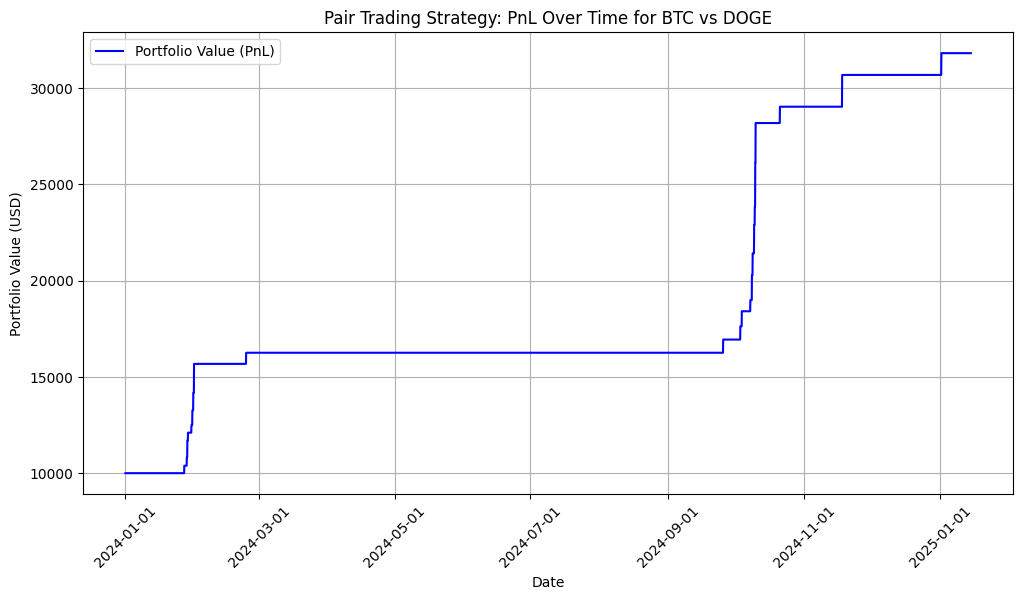

In [ ]:
..i 9mport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define initial parameters
INITIAL_CAPITAL = 10000  # Starting with $10,000 capital
LOOKBACK_PERIOD = 800  # The number of previous data points to consider for z-score calculation
Z_SCORE_THRESHOLD = 3.1  # Threshold for z-score to trigger entry
TAKE_PROFIT_PERCENT = 0.03  # Take profit at 2%
STOP_LOSS_PERCENT = 0.4 # Stop loss at 5%
MAX_HOLDING_PERIOD = 10000  # Max holding period in hours

# Load data from the uploaded CSV
file_path = "/content/drive/My Drive/combined_open_prices_1h.csv"  # Path to the uploaded CSV
data = pd.read_csv(file_path)

# Convert 'timestamp' column to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create price ratio column for BTC/DOGE
data['price_ratio_DOGE'] = data['DOGE/USDT'] / data['BTC/USDT']

# Initialize variables
price_ratios = []
trade_log = []
pnl = [INITIAL_CAPITAL]
capital = INITIAL_CAPITAL
position = None
entry_price = None
entry_time = None
bet_size = None
entry_z_score = None
entry_price_list = None
entry_mean = None
entry_std = None

# Backtesting loop for trade execution for BTC/DOGE pair
for i in range(len(data)):
    current_ratio = data['price_ratio_DOGE'].iloc[i]
    price_ratios.append(current_ratio)

    # Maintain the lookback period
    if len(price_ratios) > LOOKBACK_PERIOD:
        price_ratios.pop(0)

    if len(price_ratios) < LOOKBACK_PERIOD:
        continue

    # Calculate Z-score
    mean_ratio = np.mean(price_ratios)
    std_ratio = np.std(price_ratios)
    z_score = (current_ratio - mean_ratio) / std_ratio if std_ratio != 0 else 0

    # Identify trade entry signals
    if position is None:
        if z_score >= Z_SCORE_THRESHOLD:
            position = "Long DOGE / Short BTC"
            entry_price = current_ratio
            entry_time = data['timestamp'].iloc[i]
            entry_z_score = z_score
            entry_price_list = price_ratios.copy()  # Store the 120 values used for mean & std
            entry_mean = mean_ratio
            entry_std = std_ratio
            bet_size = capital  # Bet full capital
        elif z_score <= -Z_SCORE_THRESHOLD:
            position = "Short DOGE / Long BTC"
            entry_price = current_ratio
            entry_time = data['timestamp'].iloc[i]
            entry_z_score = z_score
            entry_price_list = price_ratios.copy()  # Store the 120 values used for mean & std
            entry_mean = mean_ratio
            entry_std = std_ratio
            bet_size = capital  # Bet full capital

    # Check for position closure based on take-profit/stop-loss or max holding period
    if position is not None:
        price_change = current_ratio - entry_price if "Long" in position else entry_price - current_ratio
        profit_percent = price_change / entry_price
        holding_period = (pd.to_datetime(data['timestamp'].iloc[i]) - pd.to_datetime(entry_time)).total_seconds() / 3600  # Convert to hours
        exit_reason = "Normal Exit"

        if profit_percent >= TAKE_PROFIT_PERCENT:
            exit_reason = "Take Profit"
        elif profit_percent <= -STOP_LOSS_PERCENT:
            exit_reason = "Stop Loss"
        elif holding_period >= MAX_HOLDING_PERIOD:
            exit_reason = "Time-Based Exit"

        if profit_percent >= TAKE_PROFIT_PERCENT or profit_percent <= -STOP_LOSS_PERCENT or holding_period >= MAX_HOLDING_PERIOD:
            profit = bet_size * profit_percent
            capital += profit
            trade_log.append([
                entry_time, data['timestamp'].iloc[i], entry_price, current_ratio,
                position, entry_z_score, bet_size, profit, profit_percent * 100,
                entry_mean, entry_std, entry_price_list, exit_reason
            ])
            position = None
            bet_size = None
            entry_z_score = None
            entry_price_list = None
            entry_mean = None
            entry_std = None

    pnl.append(capital)

# Convert trade details into DataFrame
df_trades = pd.DataFrame(trade_log, columns=[
    'Entry DateTime', 'Exit DateTime', 'Entry Price', 'Exit Price', 'Trade Type',
    'Entry Z-Score', 'Bet Size', 'Profit', 'Profit (%)', 'Mean of Last 120', 'SD of Last 120', 'Price List (Last 120)', 'Exit Reason'
])

# Save trade details to CSV
output_file = "pair_trade_results_DOGE.csv"
df_trades.to_csv(output_file, index=False)

# Plot the PnL graph for BTC/DOGE
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'][:len(pnl)], pnl, label='Portfolio Value (PnL)', color='blue')

# Formatting x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Pair Trading Strategy: PnL Over Time for BTC vs DOGE')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
>"?*# Function to download trade details CSV
def download_trade_details():
    from google.colab import files
    files.download(output_file)

# Call the function to enable download
download_trade_details()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product

# Load the uploaded CSV file
file_path = "/content/drive/My Drive/combined_open_prices_1h.csv"  # Use the correct file path
data = pd.read_csv(file_path)

# Ensure datetime is properly formatted
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Sort by datetime to avoid misalignment
data = data.sort_values(by='timestamp')

# Calculate BTC/DOGE price ratio (DOGE/BTC)
data['price_ratio_DOGE'] = data['DOGE/USDT'] / data['BTC/USDT']

# Define parameter ranges
LOOKBACK_PERIODS = [800]  # Varying the lookback period
Z_SCORE_THRESHOLDS = [2.9]  # Varying z-score thresholds
TAKE_PROFIT_PERCENTS = [0.03]  # Take profit at 2% or 3%
STOP_LOSS_PERCENTS = [0.40]  # Stop loss at 5% or 7%
MAX_HOLDING_PERIODS = [100000]  # Max holding periods

# Generate all parameter combinations
param_combinations = list(product(
    LOOKBACK_PERIODS, Z_SCORE_THRESHOLDS, TAKE_PROFIT_PERCENTS, STOP_LOSS_PERCENTS, MAX_HOLDING_PERIODS
))

# Initialize results storage
results = []

# Function to backtest each combination
def backtest_strategy(lookback, z_score_threshold, take_profit, stop_loss, max_holding):
    price_ratios = []
    trade_log = []
    pnl = [INITIAL_CAPITAL]
    capital = INITIAL_CAPITAL
    position = None
    entry_price = None
    entry_time = None
    bet_size = None
    entry_z_score = None
    entry_price_list = None
    entry_mean = None
    entry_std = None

    for i in range(len(data)):
        current_ratio = data['price_ratio_DOGE'].iloc[i]
        price_ratios.append(current_ratio)

        if len(price_ratios) > lookback:
            price_ratios.pop(0)

        if len(price_ratios) < lookback:
            continue

        mean_ratio = np.mean(price_ratios)
        std_ratio = np.std(price_ratios)
        z_score = (current_ratio - mean_ratio) / std_ratio if std_ratio != 0 else 0

        if position is None:
            if z_score >= z_score_threshold:
                position = "Long DOGE / Short BTC"
                entry_price = current_ratio
                entry_time = data['timestamp'].iloc[i]
                entry_z_score = z_score
                entry_price_list = price_ratios.copy()  # Store the 120 values used for mean & std
                entry_mean = mean_ratio
                entry_std = std_ratio
                bet_size = capital
            elif z_score <= -z_score_threshold:
                position = "Short DOGE / Long BTC"
                entry_price = current_ratio
                entry_time = data['timestamp'].iloc[i]
                entry_z_score = z_score
                entry_price_list = price_ratios.copy()  # Store the 120 values used for mean & std
                entry_mean = mean_ratio
                entry_std = std_ratio
                bet_size = capital

        if position is not None:
            price_change = current_ratio - entry_price if "Long" in position else entry_price - current_ratio
            profit_percent = price_change / entry_price
            holding_period = (data['timestamp'].iloc[i] - entry_time).total_seconds() / 3600  # Convert to hours
            exit_reason = "Normal Exit"

            if profit_percent >= take_profit:
                exit_reason = "Take Profit"
            elif profit_percent <= -stop_loss:
                exit_reason = "Stop Loss"
            elif holding_period >= max_holding:
                exit_reason = "Time-Based Exit"

            if profit_percent >= take_profit or profit_percent <= -stop_loss or holding_period >= max_holding:
                profit = bet_size * profit_percent
                capital += profit
                trade_log.append([
                    entry_time, data['timestamp'].iloc[i], entry_price, current_ratio,
                    position, entry_z_score, bet_size, profit, profit_percent * 100,
                    entry_mean, entry_std, entry_price_list, exit_reason
                ])
                position = None
                bet_size = None
                entry_z_score = None
                entry_price_list = None
                entry_mean = None
                entry_std = None

        pnl.append(capital)

    return capital, trade_log

# Run backtests for all parameter combinations
for params in param_combinations:
    final_capital, trade_log = backtest_strategy(*params)
    results.append((params, final_capital))

# Sort results by highest final capital
top_10_results = sorted(results, key=lambda x: x[1], reverse=True)[:10]

# Print top 10 parameter sets
print("Top 10 Best Parameter Combinations:")
for i, (params, capital) in enumerate(top_10_results):
    print(f"#{i+1}: Lookback={params[0]}, Z-Score={params[1]}, TP={params[2]}, SL={params[3]}, Max Holding={params[4]} -> Final Capital: {capital:.2f}")

# Optionally: Save the results to CSV for further analysis
df_results = pd.DataFrame(top_10_results, columns=["Parameters", "Final Capital"])
df_results.to_csv("best_param_results.csv", index=False)



Top 10 Best Parameter Combinations:
#1: Lookback=800, Z-Score=2.9, TP=0.03, SL=0.4, Max Holding=100000 -> Final Capital: 34491.77
